In [1]:
import os
import re
import csv
import string
import pandas as pd
import numpy as np
import statistics
import itertools
from PIL import Image
import time
from io import StringIO
from skimage import io
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import models
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision.transforms import ToTensor, Lambda, Resize, Compose, ToPILImage, Normalize, RandomCrop, RandomHorizontalFlip, RandomVerticalFlip
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import accuracy_score
from torchvision import transforms
from sklearn.model_selection import train_test_split

from tqdm import tqdm


/home/reynardo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import pandas as pd
import numpy as np

# Define directories and file paths
DIR = 'dataset/'
TRAIN_CSV = os.path.join(DIR, "train.csv")
TEST_CSV = os.path.join(DIR, "test.csv")
image_dir = os.path.join(DIR, "data")

# List all files in the image directory
all_files = set(os.listdir(image_dir))

def parse_labels(label_string, num_classes):
	labels = np.zeros(num_classes)
	for label in label_string.split():
		labels[int(label)] = 1
	return labels

# Load the CSV files with error handling
try:
	train_df = pd.read_csv(TRAIN_CSV, on_bad_lines='skip')
	test_df = pd.read_csv(TEST_CSV, on_bad_lines='skip')
except pd.errors.ParserError as e:
	print(f"Error reading CSV file: {e}")

# Save the cleaned CSV files
train_clean_csv = os.path.join(DIR, 'train_clean.csv')
test_clean_csv = os.path.join(DIR, 'test_clean.csv')
train_df.to_csv(train_clean_csv, index=False)
test_df.to_csv(test_clean_csv, index=False)

# Reload the cleaned CSV files
train_df = pd.read_csv(train_clean_csv)
test_df = pd.read_csv(test_clean_csv)


In [3]:
import numpy as np

def parse_labels(label_string, num_classes):
	labels = np.zeros(num_classes)
	for label in label_string.split():
		labels[int(label)] = 1
	return labels

# Example usage
num_classes = 20  # Adjust this based on your dataset
sample_label = '1 2 13'
binary_vector = parse_labels(sample_label, num_classes)
print(binary_vector)

[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [4]:
train_indices, val_indices = train_test_split(train_df.index, test_size=0.2, random_state=42)

# Create dataframes for training and validation sets
train_data = train_df.loc[train_indices].reset_index(drop=True)
val_data = train_df.loc[val_indices].reset_index(drop=True)

# Verify the splits
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_df)}")

# Function to parse multi-label strings
def parse_labels(label_string, num_classes):
	labels = np.zeros(num_classes)
	for label in label_string.split():
		labels[int(label)] = 1
	return labels

Training set size: 23996
Validation set size: 6000
Test set size: 9999


In [5]:
class MultiLabelDataset(Dataset):
	def __init__(self, dataframe, img_dir, num_classes, transform=None):
		self.dataframe = dataframe
		self.img_dir = img_dir
		self.num_classes = num_classes
		self.transform = transform
		self.all_files = set(os.listdir(img_dir))

	def __len__(self):
		return len(self.dataframe)

	def __getitem__(self, idx):
		img_name = self.dataframe.iloc[idx, 0].strip()
		img_path = os.path.join(self.img_dir, img_name)
		if img_name not in self.all_files:
			print(f"Warning: {img_name} not found, skipping.")
			return self.__getitem__((idx + 1) % len(self.dataframe))  # Skip to next item
		image = Image.open(img_path).convert("RGB")
		if self.transform:
			image = self.transform(image)
		labels = parse_labels(self.dataframe.iloc[idx, 1], self.num_classes)
		return image, labels






In [6]:
# Check which files are missing
missing_files = []
for img_name in train_df.iloc[:, 0]:
	if img_name.strip() not in all_files:
		missing_files.append(img_name.strip())

print(f"Missing files: {missing_files}")

Missing files: []


## Data Preprocessing- Data Agumentation

In [7]:
#num_classes = 20
max_label_index = train_df.iloc[:, 1].apply(lambda x: max(map(int, x.split()))).max()
num_classes = max_label_index + 1  # The number of classes should be one more than the maximum label index
print(f"Number of classes: {num_classes}")

Number of classes: 20


In [8]:
unique_labels = set()
train_df.iloc[:, 1].apply(lambda x: unique_labels.update(map(int, x.split())))

print(f"Unique labels in the dataset: {sorted(unique_labels)}")

Unique labels in the dataset: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]


In [9]:

train_transform = transforms.Compose([
	transforms.Resize((224, 224)),
	transforms.RandomHorizontalFlip(),       # Randomly flip the image horizontally
	transforms.RandomRotation(10),           # Randomly rotate the image by up to 10 degrees
	transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
	transforms.ToTensor(),                   # Convert image to tensor
	transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


In [10]:
test_transform = transforms.Compose([
	transforms.Resize((224, 224)),
	transforms.ToTensor(),
	transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

### Handling Data Imbalance

In [11]:
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
labels = train_df.iloc[:, 1].apply(lambda x: list(map(int, x.split())))
all_labels = [item for sublist in labels for item in sublist]
class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)


In [12]:
classes = sorted(unique_labels)

# Calculate class weights
labels = train_df.iloc[:, 1].apply(lambda x: list(map(int, x.split())))
all_labels = [item for sublist in labels for item in sublist]
class_weights = compute_class_weight('balanced', classes=np.array(classes), y=all_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [13]:
label_to_index = {label: index for index, label in enumerate(classes)}

sample_weights = []
for label_str in train_df.iloc[:, 1]:
	labels = list(map(int, label_str.split()))
	weight = sum(class_weights[label_to_index[label]] for label in labels) / len(labels)
	sample_weights.append(weight)

In [14]:
sample_weights_tensor = torch.tensor(sample_weights, dtype=torch.float)
sampler = WeightedRandomSampler(weights=sample_weights_tensor, num_samples=len(sample_weights_tensor), replacement=True)


### Create Dataset and DataLoader for training data and testing data

In [15]:
train_dataset = MultiLabelDataset(train_data, image_dir, num_classes, train_transform)
val_dataset = MultiLabelDataset(val_data, image_dir, num_classes, test_transform)
test_dataset = MultiLabelDataset(test_df, image_dir, num_classes, test_transform)

In [16]:

#train_dataset = MultiLabelDataset(train_df, image_dir, num_classes, train_transform)
#train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)

#test_dataset = MultiLabelDataset(test_df, image_dir, num_classes, test_transform)
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [17]:
# Verify data preparation by iterating through the DataLoader
for images, labels in train_loader:
	print(images.shape)
	print(labels.shape)
	print(labels[0])  # Print the first label for verification
	break  # Print only the first batch

torch.Size([8, 3, 224, 224])
torch.Size([8, 20])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.], dtype=torch.float64)


## Model Selection and Architecture

### Model 1: CNN

In [18]:
def calculate_accuracy(outputs, targets):
	outputs = torch.sigmoid(outputs) > 0.5
	targets = targets > 0.5
	accuracy = accuracy_score(targets.cpu().numpy(), outputs.cpu().numpy())
	return accuracy

# Function to calculate F1 score
def calculate_f1_score(outputs, targets):
	outputs = torch.sigmoid(outputs) > 0.5
	targets = targets > 0.5
	f1 = f1_score(targets.cpu().numpy(), outputs.cpu().numpy(), average='micro')
	return f1


In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
	history = {
		'train_loss': [],
		'val_loss': [],
		'train_acc': [],
		'val_acc': [],
		'train_f1': [],
		'val_f1': []
	}
	
	for epoch in range(num_epochs):
		model.train()
		running_loss = 0.0
		running_acc = 0.0
		running_f1 = 0.0
		
		for images, labels in tqdm(train_loader, desc="Training: "):
			
			if (torch.cuda.is_available()):
				images = images.to('cuda')
				labels = labels.to('cuda')

			outputs = model(images)
			loss = criterion(outputs, labels.float())

			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			running_loss += loss.item() * images.size(0)
			running_acc += calculate_accuracy(outputs, labels) * images.size(0)
			running_f1 += calculate_f1_score(outputs, labels) * images.size(0)
		
		epoch_loss = running_loss / len(train_loader.dataset)
		epoch_acc = running_acc / len(train_loader.dataset)
		epoch_f1 = running_f1 / len(train_loader.dataset)
		
		history['train_loss'].append(epoch_loss)
		history['train_acc'].append(epoch_acc)
		history['train_f1'].append(epoch_f1)
		
		# Validate the model
		model.eval()
		val_loss = 0.0
		val_acc = 0.0
		val_f1 = 0.0
		
		with torch.no_grad():
			for images, labels in tqdm(val_loader, desc="Validating: "):
				
				if (torch.cuda.is_available()):
					images = images.to('cuda')
					labels = labels.to('cuda')

				outputs = model(images)
				loss = criterion(outputs, labels.float())
				val_loss += loss.item() * images.size(0)
				val_acc += calculate_accuracy(outputs, labels) * images.size(0)
				val_f1 += calculate_f1_score(outputs, labels) * images.size(0)
		
		val_loss /= len(val_loader.dataset)
		val_acc /= len(val_loader.dataset)
		val_f1 /= len(val_loader.dataset)
		
		history['val_loss'].append(val_loss)
		history['val_acc'].append(val_acc)
		history['val_f1'].append(val_f1)
		
		print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, F1: {epoch_f1:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')
	
	return model, history


In [20]:
import torch
import torch.nn as nn

class CustomCNN(nn.Module):
	def __init__(self, num_classes):
		super(CustomCNN, self).__init__()
		self.features = nn.Sequential(
			nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2),
			
			nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2),
			
			nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2),
			
			nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(kernel_size=2, stride=2)
		)
		self.classifier = nn.Sequential(
			nn.Linear(512 * 14 * 14, 1024),
			nn.ReLU(inplace=True),
			nn.Dropout(0.5),
			nn.Linear(1024, num_classes)
		)
	
	def forward(self, x):
		x = self.features(x)
		x = x.view(x.size(0), -1)  # Flatten the tensor
		x = self.classifier(x)
		return x


custom_cnn_model = CustomCNN(num_classes)


In [21]:
# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(custom_cnn_model.parameters(), lr=0.001)


### AlexNet

In [22]:
import torchvision.models as models

# Define the AlexNet-based model
class AlexNetMultiLabel(nn.Module):
	def __init__(self, num_classes):
		super(AlexNetMultiLabel, self).__init__()
		self.alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
		self.alexnet.classifier[6] = nn.Linear(4096, num_classes)
	
	def forward(self, x):
		return self.alexnet(x)

# Define the ResNet-based model
class ResNetMultiLabel(nn.Module):
	def __init__(self, num_classes):
		super(ResNetMultiLabel, self).__init__()
		self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
		self.resnet.fc = nn.Linear(2048, num_classes)
	
	def forward(self, x):
		return self.resnet(x)


alexnet_model = AlexNetMultiLabel(num_classes)
resnet_model = ResNetMultiLabel(num_classes)


### Train and Evaluate

In [23]:
# Plot metrics
def plot_metrics(history, title):
	epochs = range(1, len(history['train_loss']) + 1)

	plt.figure(figsize=(12, 4))

	plt.subplot(1, 3, 1)
	plt.plot(epochs, history['train_loss'], label='Training Loss')
	plt.plot(epochs, history['val_loss'], label='Validation Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.title(f'{title} Loss')
	plt.legend()

	plt.subplot(1, 3, 2)
	plt.plot(epochs, history['train_acc'], label='Training Accuracy')
	plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
	plt.xlabel('Epochs')
	plt.ylabel('Accuracy')
	plt.title(f'{title} Accuracy')
	plt.legend()

	plt.subplot(1, 3, 3)
	plt.plot(epochs, history['train_f1'], label='Training F1 Score')
	plt.plot(epochs, history['val_f1'], label='Validation F1 Score')
	plt.xlabel('Epochs')
	plt.ylabel('F1 Score')
	plt.title(f'{title} F1 Score')
	plt.legend()

	plt.tight_layout()
	plt.show()



Using GPU


Validating: 100%|██████████| 750/750 [00:22<00:00, 33.92it/s]


Epoch 1/1, Loss: 0.1861, Acc: 0.4699, F1: 0.6032, Val Loss: 0.1824, Val Acc: 0.4620, Val F1: 0.5983


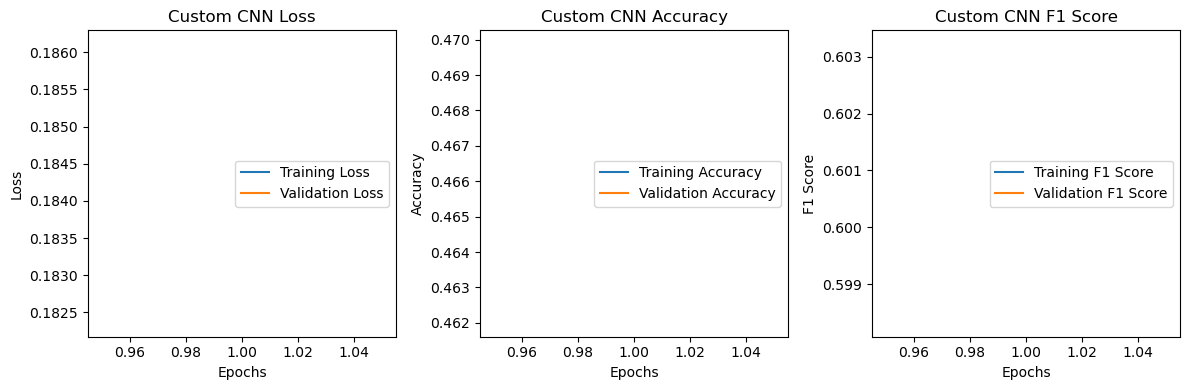

Validating: 100%|██████████| 750/750 [00:13<00:00, 53.96it/s]


Epoch 1/1, Loss: 0.2026, Acc: 0.4696, F1: 0.6027, Val Loss: 0.1856, Val Acc: 0.4617, Val F1: 0.5972


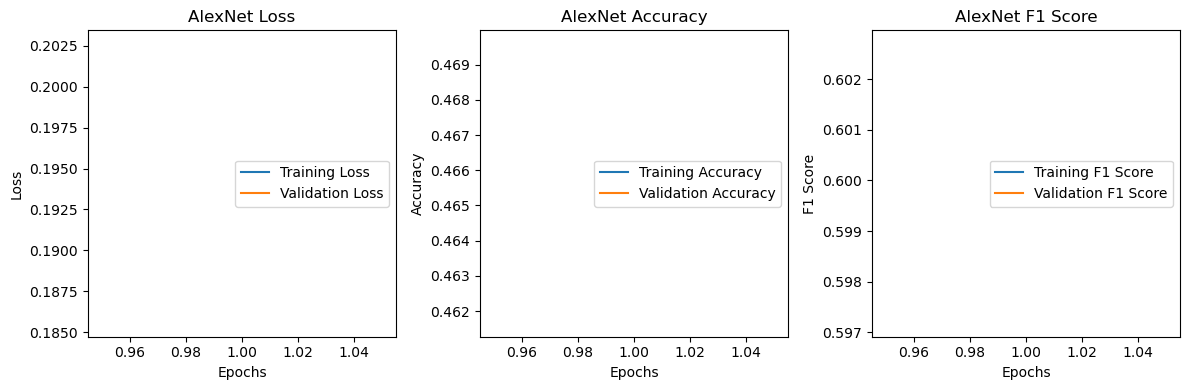

In [24]:
if (torch.cuda.is_available()):
    print("Using GPU")
    custom_cnn_model = custom_cnn_model.to('cuda')
    alexnet_model = alexnet_model.to('cuda')
    resnet_model = resnet_model.to('cuda')

# Custom CNN
optimizer_custom = torch.optim.Adam(custom_cnn_model.parameters(), lr=0.001)
custom_cnn_model, custom_cnn_history = train_model(custom_cnn_model, train_loader, val_loader, criterion, optimizer_custom, num_epochs=1)
plot_metrics(custom_cnn_history, "Custom CNN")

# AlexNet
optimizer_alexnet = torch.optim.Adam(alexnet_model.parameters(), lr=0.001)
alexnet_model, alexnet_history = train_model(alexnet_model, train_loader, val_loader, criterion, optimizer_alexnet, num_epochs=1)
plot_metrics(alexnet_history, "AlexNet")

# ResNet
# optimizer_resnet = torch.optim.Adam(resnet_model.parameters(), lr=0.001)
# resnet_model, resnet_history = train_model(resnet_model, train_loader, val_loader, criterion, optimizer_resnet, num_epochs=1)
# plot_metrics(resnet_history, "ResNet")

## Hybrid Approach

In [24]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Function to tokenize and embed text
def tokenize_text(text, max_length=128):
	encoding = tokenizer.encode_plus(
		text,
		add_special_tokens=True,
		max_length=max_length,
		return_token_type_ids=False,
		padding='max_length',
		return_attention_mask=True,
		return_tensors='pt',
	)
	return encoding['input_ids'].flatten(), encoding['attention_mask'].flatten()


/home/reynardo/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [25]:
class MultiModalDataset(Dataset):
	def __init__(self, dataframe, img_dir, num_classes, transform=None, max_length=128):
		self.dataframe = dataframe
		self.img_dir = img_dir
		self.num_classes = num_classes
		self.transform = transform
		self.max_length = max_length
		self.all_files = set(os.listdir(img_dir))

	def __len__(self):
		return len(self.dataframe)

	def __getitem__(self, idx):
		img_name = self.dataframe.iloc[idx, 0].strip()
		img_path = os.path.join(self.img_dir, img_name)
		if img_name not in self.all_files:
			print(f"Warning: {img_name} not found, skipping.")
			return self.__getitem__((idx + 1) % len(self.dataframe))  # Skip to next item
		image = Image.open(img_path).convert("RGB")
		if self.transform:
			image = self.transform(image)
		
		text = self.dataframe.iloc[idx, 2]  # Assuming the text is in the third column
		input_ids, attention_mask = tokenize_text(text, self.max_length)
		labels = parse_labels(self.dataframe.iloc[idx, 1], self.num_classes)
		
		return {
			'image': image,
			'input_ids': input_ids,
			'attention_mask': attention_mask,
			'labels': torch.tensor(labels, dtype=torch.float)
		}

In [26]:

train_dataset = MultiModalDataset(train_data, image_dir, num_classes, train_transform)
val_dataset = MultiModalDataset(val_data, image_dir, num_classes, test_transform)
test_dataset = MultiModalDataset(test_df, image_dir, num_classes, test_transform)

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [27]:
class CNNExtractor(nn.Module):
	def __init__(self):
		super(CNNExtractor, self).__init__()
		self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
		self.resnet.fc = nn.Identity()  # Remove the final classification layer
	
	def forward(self, x):
		return self.resnet(x)


In [28]:
class BERTExtractor(nn.Module):
	def __init__(self, bert_model):
		super(BERTExtractor, self).__init__()
		self.bert = bert_model
	
	def forward(self, input_ids, attention_mask):
		outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
		return outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation


In [29]:
class MultiModalModel(nn.Module):
	def __init__(self, cnn_model, bert_model, num_classes):
		super(MultiModalModel, self).__init__()
		self.cnn_extractor = cnn_model
		self.bert_extractor = BERTExtractor(bert_model)
		self.fc = nn.Sequential(
			nn.Linear(2048 + 768, 1024),  # Assuming ResNet and BERT dimensions
			nn.ReLU(),
			nn.Dropout(0.5),
			nn.Linear(1024, num_classes)
		)
	
	def forward(self, image, input_ids, attention_mask):
		image_features = self.cnn_extractor(image)
		text_features = self.bert_extractor(input_ids, attention_mask)
		combined_features = torch.cat((image_features, text_features), dim=1)
		return self.fc(combined_features)

# Instantiate the model
cnn_model = CNNExtractor()
bert_model = bert_model
multi_modal_model = MultiModalModel(cnn_model, bert_model, num_classes)


In [30]:
# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(multi_modal_model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
	history = {
		'train_loss': [],
		'val_loss': [],
		'train_acc': [],
		'val_acc': [],
		'train_f1': [],
		'val_f1': []
	}
	
	for epoch in range(num_epochs):
		model.train()
		running_loss = 0.0
		running_acc = 0.0
		running_f1 = 0.0
		
		for batch in tqdm(train_loader, desc="Training: "):

			images = batch['image']
			input_ids = batch['input_ids']
			attention_mask = batch['attention_mask']
			labels = batch['labels']

			if (torch.cuda.is_available()):
				images = images.to('cuda')
				input_ids = input_ids.to('cuda')
				attention_mask = attention_mask.to('cuda')
				labels = labels.to('cuda')
			
			outputs = model(images, input_ids, attention_mask)
			loss = criterion(outputs, labels)
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			running_loss += loss.item() * images.size(0)
			running_acc += calculate_accuracy(outputs, labels) * images.size(0)
			running_f1 += calculate_f1_score(outputs, labels) * images.size(0)
		
		epoch_loss = running_loss / len(train_loader.dataset)
		epoch_acc = running_acc / len(train_loader.dataset)
		epoch_f1 = running_f1 / len(train_loader.dataset)
		
		history['train_loss'].append(epoch_loss)
		history['train_acc'].append(epoch_acc)
		history['train_f1'].append(epoch_f1)
		
		# Validate the model
		model.eval()
		val_loss = 0.0
		val_acc = 0.0
		val_f1 = 0.0
		
		with torch.no_grad():
			for batch in tqdm(val_loader, desc="Validating: "):
				images = batch['image']
				input_ids = batch['input_ids']
				attention_mask = batch['attention_mask']
				labels = batch['labels']

				if (torch.cuda.is_available()):
					images = images.to('cuda')
					input_ids = input_ids.to('cuda')
					attention_mask = attention_mask.to('cuda')
					labels = labels.to('cuda')
				
				outputs = model(images, input_ids, attention_mask)
				loss = criterion(outputs, labels)
				val_loss += loss.item() * images.size(0)
				val_acc += calculate_accuracy(outputs, labels) * images.size(0)
				val_f1 += calculate_f1_score(outputs, labels) * images.size(0)
		
		val_loss /= len(val_loader.dataset)
		val_acc /= len(val_loader.dataset)
		val_f1 /= len(val_loader.dataset)
		
		history['val_loss'].append(val_loss)
		history['val_acc'].append(val_acc)
		history['val_f1'].append(val_f1)
		
		print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, F1: {epoch_f1:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')
	
	return model, history




In [31]:
# Train the multi-modal model
if (torch.cuda.is_available()):
    print("Using GPU")
    multi_modal_model = multi_modal_model.to('cuda')

multi_modal_model, history = train_model(multi_modal_model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Using GPU


Validating: 100%|██████████| 750/750 [01:10<00:00, 10.68it/s]


Epoch 1/10, Loss: 0.1861, Acc: 0.4687, F1: 0.6017, Val Loss: 0.1766, Val Acc: 0.4620, Val F1: 0.5983


Validating: 100%|██████████| 750/750 [01:09<00:00, 10.76it/s]


Epoch 2/10, Loss: 0.1784, Acc: 0.4710, F1: 0.6042, Val Loss: 0.1733, Val Acc: 0.4620, Val F1: 0.5984


Validating: 100%|██████████| 750/750 [01:09<00:00, 10.75it/s]


Epoch 3/10, Loss: 0.1743, Acc: 0.4707, F1: 0.6036, Val Loss: 0.1843, Val Acc: 0.4620, Val F1: 0.5983


Validating: 100%|██████████| 750/750 [01:09<00:00, 10.78it/s]


Epoch 4/10, Loss: 0.1729, Acc: 0.4707, F1: 0.6037, Val Loss: 0.1684, Val Acc: 0.4620, Val F1: 0.5983


Validating: 100%|██████████| 750/750 [01:09<00:00, 10.78it/s]


Epoch 5/10, Loss: 0.1708, Acc: 0.4707, F1: 0.6035, Val Loss: 0.1715, Val Acc: 0.4605, Val F1: 0.5993


Validating: 100%|██████████| 750/750 [01:09<00:00, 10.78it/s]


Epoch 6/10, Loss: 0.1697, Acc: 0.4700, F1: 0.6044, Val Loss: 0.1655, Val Acc: 0.4618, Val F1: 0.5981


Validating: 100%|██████████| 750/750 [01:09<00:00, 10.82it/s]


Epoch 7/10, Loss: 0.1678, Acc: 0.4691, F1: 0.6024, Val Loss: 0.1661, Val Acc: 0.4618, Val F1: 0.5991


Validating: 100%|██████████| 750/750 [01:09<00:00, 10.75it/s]


Epoch 8/10, Loss: 0.1655, Acc: 0.4663, F1: 0.6029, Val Loss: 0.1628, Val Acc: 0.4607, Val F1: 0.5985


Validating: 100%|██████████| 750/750 [01:09<00:00, 10.80it/s]


Epoch 9/10, Loss: 0.1638, Acc: 0.4662, F1: 0.6032, Val Loss: 0.1646, Val Acc: 0.4582, Val F1: 0.6068


Validating: 100%|██████████| 750/750 [01:09<00:00, 10.80it/s]

Epoch 10/10, Loss: 0.1621, Acc: 0.4627, F1: 0.6030, Val Loss: 0.1640, Val Acc: 0.4452, Val F1: 0.6007


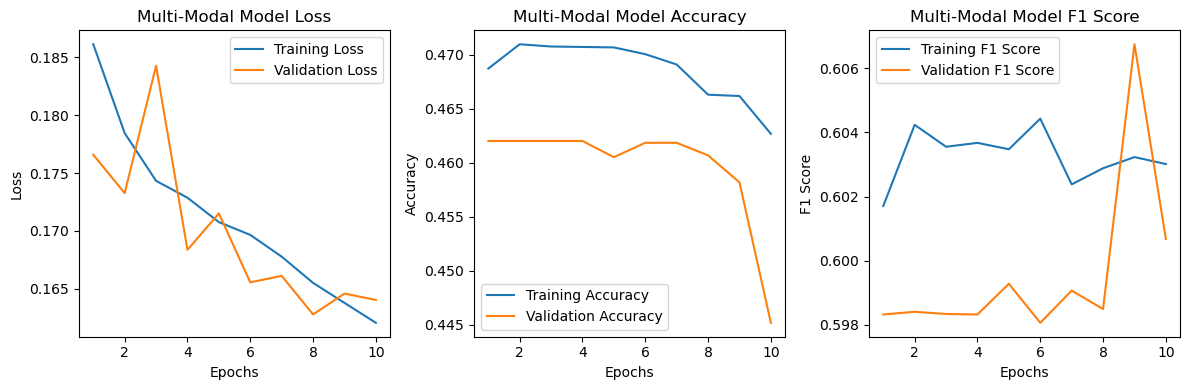

In [32]:
def plot_metrics(history, title):
	epochs = range(1, len(history['train_loss']) + 1)

	plt.figure(figsize=(12, 4))

	plt.subplot(1, 3, 1)
	plt.plot(epochs, history['train_loss'], label='Training Loss')
	plt.plot(epochs, history['val_loss'], label='Validation Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.title(f'{title} Loss')
	plt.legend()

	plt.subplot(1, 3, 2)
	plt.plot(epochs, history['train_acc'], label='Training Accuracy')
	plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
	plt.xlabel('Epochs')
	plt.ylabel('Accuracy')
	plt.title(f'{title} Accuracy')
	plt.legend()

	plt.subplot(1, 3, 3)
	plt.plot(epochs, history['train_f1'], label='Training F1 Score')
	plt.plot(epochs, history['val_f1'], label='Validation F1 Score')
	plt.xlabel('Epochs')
	plt.ylabel('F1 Score')
	plt.title(f'{title} F1 Score')
	plt.legend()

	plt.tight_layout()
	plt.show()

plot_metrics(history, "Multi-Modal Model")


### Pretrained Data

In [33]:
import optuna

# Ensure bert_model is defined globally
bert_model = BertModel.from_pretrained('bert-base-uncased')

def objective(trial):
	# Hyperparameters to tune
	lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
	dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
	batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
	
	# Update DataLoader with new batch size
	train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
	val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
	
	# Define the model
	class MultiModalModel(nn.Module):
		def __init__(self, cnn_model, bert_model, num_classes, dropout_rate):
			super(MultiModalModel, self).__init__()
			self.cnn_extractor = cnn_model
			self.bert_extractor = BERTExtractor(bert_model)
			self.fc = nn.Sequential(
				nn.Linear(2048 + 768, 1024),  # Assuming ResNet and BERT dimensions
				nn.ReLU(),
				nn.Dropout(dropout_rate),
				nn.Linear(1024, num_classes)
			)
		
		def forward(self, image, input_ids, attention_mask):
			image_features = self.cnn_extractor(image)
			text_features = self.bert_extractor(input_ids, attention_mask)
			combined_features = torch.cat((image_features, text_features), dim=1)
			return self.fc(combined_features)
	
	# Instantiate the model
	cnn_model = CNNExtractor()
	num_classes = 20  # Adjust this based on your dataset
	model = MultiModalModel(cnn_model, bert_model, num_classes, dropout_rate)
	
	# Define the loss function and optimizer
	criterion = nn.BCEWithLogitsLoss()
	optimizer = torch.optim.Adam(model.parameters(), lr=lr)
	
	# Training loop
	def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
		best_val_loss = float('inf')
		
		for epoch in range(num_epochs):
			model.train()
			running_loss = 0.0
			for batch in train_loader:
				images = batch['image']
				input_ids = batch['input_ids']
				attention_mask = batch['attention_mask']
				labels = batch['labels']
				
				outputs = model(images, input_ids, attention_mask)
				loss = criterion(outputs, labels)
				optimizer.zero_grad()
				loss.backward()
				optimizer.step()
				running_loss += loss.item() * images.size(0)
			
			epoch_loss = running_loss / len(train_loader.dataset)
			
			# Validate the model
			model.eval()
			val_loss = 0.0
			with torch.no_grad():
				for batch in val_loader:
					images = batch['image']
					input_ids = batch['input_ids']
					attention_mask = batch['attention_mask']
					labels = batch['labels']
					
					outputs = model(images, input_ids, attention_mask)
					loss = criterion(outputs, labels)
					val_loss += loss.item() * images.size(0)
			
			val_loss /= len(val_loader.dataset)
			
			if val_loss < best_val_loss:
				best_val_loss = val_loss
			
			print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')
		
		return best_val_loss
	
	best_val_loss = train_model(model, train_loader, val_loader, criterion, optimizer)
	
	return best_val_loss

# Perform hyperparameter tuning
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best hyperparameters: ", study.best_params)
best_params = study.best_params



ModuleNotFoundError: No module named 'optuna'

In [ ]:
class CNNExtractor(nn.Module):
	def __init__(self):
		super(CNNExtractor, self).__init__()
		self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
		self.resnet.fc = nn.Identity()  # Remove the final classification layer
	
	def forward(self, x):
		return self.resnet(x)

# Define the BERT model for text features
class BERTExtractor(nn.Module):
	def __init__(self, bert_model):
		super(BERTExtractor, self).__init__()
		self.bert = bert_model
	
	def forward(self, input_ids, attention_mask):
		outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
		return outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation

# Define the MultiModalModel
class MultiModalModel(nn.Module):
	def __init__(self, cnn_model, bert_model, num_classes, dropout_rate):
		super(MultiModalModel, self).__init__()
		self.cnn_extractor = cnn_model
		self.bert_extractor = BERTExtractor(bert_model)
		self.fc = nn.Sequential(
			nn.Linear(2048 + 768, 1024),  # Assuming ResNet and BERT dimensions
			nn.ReLU(),
			nn.Dropout(dropout_rate),
			nn.Linear(1024, num_classes)
		)
	
	def forward(self, image, input_ids, attention_mask):
		image_features = self.cnn_extractor(image)
		text_features = self.bert_extractor(input_ids, attention_mask)
		combined_features = torch.cat((image_features, text_features), dim=1)
		return self.fc(combined_features)

# Initialize the best model with the best hyperparameters
best_cnn_model = CNNExtractor()
bert_model = BertModel.from_pretrained('bert-base-uncased')
best_model = MultiModalModel(best_cnn_model, bert_model, num_classes, best_params['dropout_rate'])

# Define the optimizer with the best learning rate
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['lr'])

# Define image transformations for test data
test_transform = transforms.Compose([
	transforms.Resize((224, 224)),
	transforms.ToTensor(),
	transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


In [ ]:
def generate_predictions(model, test_loader):
	model.eval()
	predictions = []
	with torch.no_grad():
		for batch in test_loader:
			images = batch['image']
			input_ids = batch['input_ids']
			attention_mask = batch['attention_mask']
			
			outputs = model(images, input_ids, attention_mask)
			preds = torch.sigmoid(outputs).cpu().numpy()
			predictions.append(preds)
	
	return np.vstack(predictions)

# Generate predictions on the test set
test_predictions = generate_predictions(best_model, test_loader)


In [ ]:
# Function to generate predictions
def generate_predictions(model, test_loader):
	model.eval()
	predictions = []
	with torch.no_grad():
		for batch in test_loader:
			images = batch['image']
			input_ids = batch['input_ids']
			attention_mask = batch['attention_mask']
			
			outputs = model(images, input_ids, attention_mask)
			preds = torch.sigmoid(outputs).cpu().numpy()
			predictions.append(preds)
	
	return np.vstack(predictions)

# Generate predictions on the test set
test_predictions = generate_predictions(best_model, test_loader)


In [ ]:
# Create a DataFrame with predictions
submission_df = test_df.copy()
submission_df.iloc[:, 1:] = test_predictions

# Save to CSV
submission_df.to_csv('/Users/sanaali/Downloads/COMP5329S1A2Dataset 2/submission.csv', index=False)
